## Task 1

In [368]:
from keras import datasets
import numpy as np
#from keras.models import Sequential
#from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from numpy.random import default_rng
import matplotlib.pyplot as plt

rng = default_rng()
encoder = OneHotEncoder()
encoder2= OneHotEncoder()

data = datasets.mnist.load_data()

(X_train, y_train), (X_test, y_test) = data

#print(datasets.mnist.load_data())

X_train = X_train / 255
X_test = X_test / 255

X_train = np.reshape(X_train, [60000, 28 * 28])
X_test = np.reshape(X_test, [10000, 28 * 28])

encoder = encoder.fit_transform(y_train.reshape(1, -1))
encoder2= encoder2.fit_transform(y_test.reshape(1, -1))
#y_train = np.reshape(y_train, [60000, 1])
#y_test = np.reshape(y_test, [10000, 1])

print(X_train[0])
print(y_test)

print(y_train.shape)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [384]:
class Activation_Layer_ReLU:
    
    def forward_pass(self, x):
        
        return np.maximum(0, x)
    
    def backward_pass(self, x):
        
        return (x > 0) * 1
    

In [385]:
class Activation_Layer_Sigmoid:
    
    def forward_pass(self, x):
        
        #print("TEST 2")
        self.sigmoid = 1 / (1 + np.exp(-x))
        
        return self.sigmoid
    
    def backward_pass(self, x):
        
        #print("Test")
        
        return self.sigmoid * (1 - self.sigmoid)


In [386]:
class Activation_Layer_Softmax:
    
    def forward_pass(self, x):
        
        exponents = np.exp(x - np.max(x, axis = 1, keepdims = True))
        
        self.softmax_out = (exponents) / np.sum(exponents, axis = 1, keepdims = True)
        
        return self.softmax_out
    
    def backward_pass(self, dvalues):
        
        #softmax = self.softmax(x)
        
        #return np.diag(softmax) + (softmax * softmax.reshape(14000, 784))
        
        """print("DV:", dvalues.shape)
        
        jacobian = dvalues[:, :, None] * dvalues[:, None, :]
        #print("Jaco", jacobian.shape)
        
        iy, ix = np.diag_indices_from(dvalues)
        jacobian[:, iy, ix] = dvalues * (1.0 - dvalues)
        
        self.dinputs = np.sum(jacobian, axis = 1)"""
        
        self.dinputs = np.empty_like(dvalues) # Create empty array same size as input gradients
        
        #print(self.softmax_out.shape)
        
        for idx, (single_output, single_dvalue) in enumerate(zip(self.softmax_out, dvalues)):
            
            single_output = single_output.reshape(-1, 1) # Flatten output
            
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T) # Create a jacobian matrix 
            
            self.dinputs[idx] = np.dot(jacobian_matrix, single_dvalue) # Calculate sample-wise gradients
        
        return self.dinputs
    
        """#d_vector = dvalues.flatten()
        #d_matrix = np.tile(dvalues, dvalues.shape[1])
        
        #test = np.diag(dvalues) - np.dot(d_matrix, d_matrix.T)
        
        #print("TEST:", test)
        
        s_max = self.softmax_out.copy()
        
        si_sj = np.dot(self.softmax_out.flatten(), self.softmax_out.flatten().T)
        
        print("AAAAAAAAAAAAAAAAAA", self.softmax_out.T.flatten().shape)
        
        #print(s)
        print("PPPPPPPPPPPPP", si_sj.shape)
        s_der = np.diag(self.softmax_out.flatten()) - si_sj
        print("S_DER", np.diag(self.softmax_out).shape)
        
        #s = self.softmax_out.reshape(-1, 1)
        
        #self.dinputs = np.diagflat(s) - np.dot(s, s.T)
        self.test = s_der
        
        print("######", self.test.shape, self.dinputs.shape)"""


In [387]:
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons):
        
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward_pass(self, x):
        
        self.x = x
        
        return np.dot(x, self.weights) + self.biases
    
    def backward_pass(self, dvalues):
        
        self.dweights = np.dot(self.x.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        
        return self.dinputs
    
    def set_weights(self, weights):
        
        self.weights = weights
    
    def set_biases(self, biases):
        
        self.biases = biases

In [388]:
class Loss:
    
    def calculate_mean_loss(self, y_pred, y_true):
        
        mean_loss = np.mean(self.forward_propogation(y_pred, y_true))
        #mean_loss = self.forward_propogation(y_pred, y_true)
        
        return mean_loss
        

In [389]:
class Loss_Cross_Entropy(Loss):
    
    def forward_propogation(self, y_pred, y_true):
        
        samples = len(y_pred)
        
        if len(y_true.shape) == 1:
            
            #print("A:", y_pred.shape, y_true.shape, range(samples))
            
            confidence = y_pred[range(samples), y_true]
        
        elif len(y_true.shape) == 2:
            
            confidence = np.sum(y_pred * y_true, axis = 1)
            
        neg_log_likelihood = -np.log(confidence)
        
        #neg_log_likelihood = - np.sum(np.dot(y_true, np.log(y_pred)))
        #-sum([p[i]*log(q[i])
        
        #neg_log_likelihood = np.mean((-1/len(y_true)) * (np.sum(y_true * np.log(y_pred.T), axis = 1)))
        
        return neg_log_likelihood
     
    def backward_propogation(self, dvalues, y_true):
        
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = (-y_true / dvalues) / samples

        return self.dinputs
        

In [390]:
class Activation_Softmax_Layer_Loss_Cross_Entropy:
    
    def __init__(self):
        self.activation = Activation_Layer_Softmax()
        self.loss = Loss_Cross_Entropy()
        
    def forward_pass(self, x, y_true):
        
        self.softmax_output = self.activation.forward_pass(x)
        self.mean_loss = self.loss.calculate_mean_loss(self.softmax_output, y_true)
        
        return self.mean_loss
        
    def backward_pass(self, dvalues, y_true):
        
        samples = len(dvalues)
        
        #if len(y_true.shape) == 2:
        #    
        #    y_true = np.argmax(y_true, axis = 1)
            
        self.dinputs = dvalues.copy()
        
        self.dinputs[range(samples), y_true] -= 1
        
        #self.dinputs = (self.softmax_output.T - y_true) * self.activation.backward_pass(dvalues).T
        
        return self.dinputs
    

In [391]:
class Optimiser_SGD:
    
    def __init__(self, learning_rate = 0.5):
        
        self.learning_rate = learning_rate
    
    def update_values(self, layer):
        
        #print("A")
        #print(layer.weights)
        
        #print("####################################")
        #print(layer.dweights)
        
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases
        
        #print("B")
        #print(layer.weights)
        
        return layer.weights, layer.biases
        

In [398]:
# Set Hyperparameters

learning_rate = 0.01
epochs = 25
image_size = 28 * 28 # image size is 28x28 pixels
input_layer_size = X_train.shape[1]
hidden_layer_size = 150 # chosen size of hidden layer; can be any number
output_layer_size = 10 # becuase of digits from 0 to 9

In [399]:
dense_layer1 = Layer_Dense(X_train.shape[1], hidden_layer_size)

activation_layer1 = Activation_Layer_ReLU()

dense_layer2 = Layer_Dense(hidden_layer_size, hidden_layer_size)

activation_layer2 = Activation_Layer_Sigmoid()

dense_layer3 = Layer_Dense(hidden_layer_size, output_layer_size)

activation_layer3 = Activation_Layer_Softmax()

loss_function = Loss_Cross_Entropy()

loss_activation = Activation_Softmax_Layer_Loss_Cross_Entropy()

optimiser = Optimiser_SGD(learning_rate = learning_rate)


In [400]:
from sklearn.metrics import accuracy_score

In [401]:
loss_history = []
accuracy_history = []

for iteration in range(epochs):
    
    #print("ReLU")
    dense_layer1_forward = dense_layer1.forward_pass(X_train)    
    activation_layer1_forward = activation_layer1.forward_pass(dense_layer1_forward)

    #print("Sig")
    dense_layer2_forward = dense_layer2.forward_pass(activation_layer1_forward)
    activation_layer2_forward = activation_layer2.forward_pass(dense_layer2_forward)

    #print(activation_layer1_forward)
    
    #print("Soft")
    dense_layer3_forward = dense_layer3.forward_pass(activation_layer2_forward)
    #activation_layer3_forward = activation_layer3.forward_pass(dense_layer3_forward)
    
    #print(y_test.shape)
    
    #print(activation_layer3_forward)
    
    #print("Loss")
    #loss = loss_function.calculate_mean_loss(activation_layer3_forward, y_train)
    
    loss_activation.forward_pass(dense_layer3_forward, y_train)
    
    activation_layer3_forward = loss_activation.softmax_output
    loss = loss_activation.mean_loss
    
    #print("Loss:", loss)
    
    y_pred = np.argmax(activation_layer3_forward, axis = 1)
    
    accuracy = np.mean(y_pred == y_train)
    #accuracy = accuracy_score(y_train, y_pred)

    #print("Accuracy:", accuracy)
    
    loss_history.append(loss)
    accuracy_history.append(accuracy)
    
    if iteration % 1 == 0:
        
        print("iteration:", iteration, "loss:", loss, "acc:", accuracy)
    
    
    #Backward Pass
    
    #print("Soft Back")
    #loss_activation_backward = loss_function.backward_propogation(activation_layer3_forward, y_train)
    loss_activation_backward = loss_activation.backward_pass(activation_layer3_forward, y_train)
    
    #activation_layer3_backward = activation_layer3.backward_pass(loss_activation_backward)    
    dense_layer3_backward = dense_layer3.backward_pass(loss_activation_backward)
    
    #print("Sig Back")
    activation_layer2_backward = activation_layer2.backward_pass(dense_layer3_backward)
    dense_layer2_backward = dense_layer2.backward_pass(activation_layer2_backward)
    
    #print("ReLU Back")
    activation_layer1_backward = activation_layer1.backward_pass(dense_layer2_backward)    
    dense_layer1.backward_pass(activation_layer1_backward)
    
    #dense_layer3_backward = dense_layer3.backward_pass(loss_function.calculate_mean_loss(activation_layer3_forward, y_train), y_train)
    
    #print("BEFORE")
    #print(dense_layer1.weights)
    
    #old_weights = dense_layer1.weights.copy()
    
    #dense_layer1.set_weights(optimiser.update_values(dense_layer1)[0])
    #optimiser.update_values(dense_layer1)
    #optimiser.update_values(dense_layer2)
    #optimiser.update_values(dense_layer3)
    
    old_weight = dense_layer1.weights.copy()
    
    #print("AFTER")
    #print("BEFORE")
    #print(old_weight)
    
    dense_layer1.weights -= learning_rate * dense_layer1.dweights
    dense_layer1.biases -= learning_rate * dense_layer1.dbiases
    
    #print("AFTER")
    #print(dense_layer1.weights)
    
    #print("dweights")
    #print(dense_layer1.dweights)
    
    dense_layer2.weights -= learning_rate * dense_layer2.dweights
    dense_layer2.biases -= learning_rate * dense_layer2.dbiases
    
    dense_layer3.weights -= learning_rate * dense_layer3.dweights
    dense_layer3.biases -= learning_rate * dense_layer3.dbiases
    
    """
    if iteration % 50 == 0:
        
        print("iteration:", iteration, "loss:", loss, "acc:", accuracy)
        
    #if iteration % 250 == 0:
    loss_history.append(loss)
    accuracy_history.append(accuracy)
    
    
    """
    
    
print("iteration:", iteration, "loss:", loss, "acc:", accuracy)        

iteration: 0 loss: 2.3050687743599494 acc: 0.09751666666666667


C:\Users\riyaa\AppData\Local\Temp\ipykernel_27860\3515690038.py:6: RuntimeWarning: overflow encountered in exp
  self.sigmoid = 1 / (1 + np.exp(-x))


iteration: 1 loss: 46.03607709076158 acc: 0.11236666666666667


C:\Users\riyaa\AppData\Local\Temp\ipykernel_27860\22039993.py:17: RuntimeWarning: divide by zero encountered in log
  neg_log_likelihood = -np.log(confidence)


iteration: 2 loss: inf acc: 0.10441666666666667
iteration: 3 loss: inf acc: 0.10218333333333333
iteration: 4 loss: inf acc: 0.09915
iteration: 5 loss: inf acc: 0.09736666666666667
iteration: 6 loss: inf acc: 0.09751666666666667


KeyboardInterrupt: 

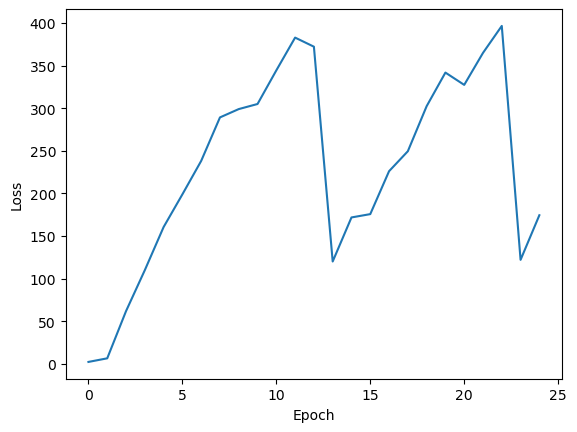

In [396]:
plt.plot(range(int(epochs)), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

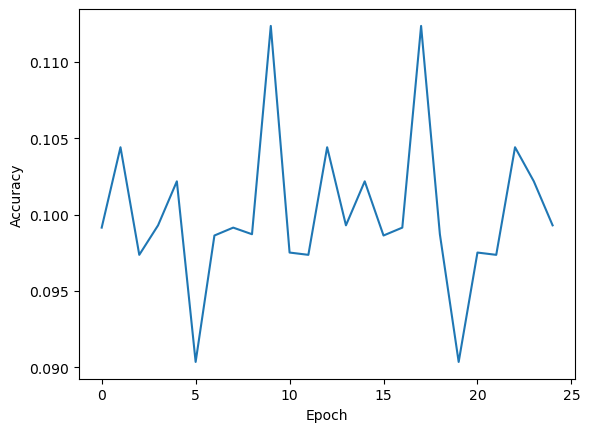

In [397]:
plt.plot(range(int(epochs)), accuracy_history)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [535]:
print(y_pred)

print("TRAIN")
print(y_train)

print(np.mean(y_pred == y_train))

[0 0 0 ... 0 0 0]
TRAIN
[5 0 4 ... 5 6 8]
0.10533333333333333


In [523]:
print(activation_layer3_forward)

[[1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 ...
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]]


In [48]:
print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 12.739091058244902
Accuracy: 0.4186166666666667


## -----------------------------------------------------------------------------------------------------------------------------

In [235]:
dense_layer1_forward = dense_layer1.forward_pass(X_train)

#print(X_train.shape[1])
#print(dense_layer1_forward.shape)

activation_layer1_forward = activation_layer1.forward_pass(dense_layer1_forward)

dense_layer2_forward = dense_layer2.forward_pass(activation_layer1_forward)

activation_layer2_forward = activation_layer2.forward_pass(dense_layer2_forward)

dense_layer3_forward = dense_layer3.forward_pass(activation_layer2_forward)

activation_layer3_forward = activation_layer3.forward_pass(dense_layer3_forward)

#print(y_test.shape)

print(activation_layer3_forward)

loss = loss_function.calculate_mean_loss(activation_layer3_forward, y_train)

print("Loss:", loss)

[[1.67590275e-06 1.65152065e-06 1.65721082e-06 ... 1.65715403e-06
  1.67848615e-06 1.67018360e-06]
 [1.67588782e-06 1.65155903e-06 1.65721330e-06 ... 1.65719159e-06
  1.67850166e-06 1.67018850e-06]
 [1.67591281e-06 1.65160950e-06 1.65722753e-06 ... 1.65719984e-06
  1.67855277e-06 1.67021450e-06]
 ...
 [1.67591354e-06 1.65152998e-06 1.65723682e-06 ... 1.65715801e-06
  1.67850356e-06 1.67018524e-06]
 [1.67590307e-06 1.65158943e-06 1.65719749e-06 ... 1.65718721e-06
  1.67852821e-06 1.67022410e-06]
 [1.67589272e-06 1.65154629e-06 1.65720792e-06 ... 1.65716691e-06
  1.67847822e-06 1.67018461e-06]]
Loss: 13.304818431623891


In [236]:
predictions = np.argmax(activation_layer3_forward, axis = 1)

accuracy = np.mean(predictions == y_train)

print("Accuracy:", accuracy)

Accuracy: 0.10218333333333333


## -----------------------------------------------------------------------------------------------------------------------------

In [1]:
class NeuralNetwork:
    
    def __init__(self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    
        

In [53]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

def relu(x):
    
    return np.maximum(0, x)

w1 = rng.random((image_size, hidden_layer_size))
w2 = rng.random((hidden_layer_size, output_layer_size))

print(w1.shape)

for i in range(epochs):
    
    loss = 0.0
    
    for j in range(len(X_train)):
        
        layer_0 = X_train[j]
        
        layer_1 = np.dot(layer_0, w1)
        layer_1 = relu(layer_1)
        
        layer_2 = np.dot(layer_1, w2)
    

(784, 100)
